## Some thoughts:
    
1. The topics formed are an easy giveaway to achieve at least 5 out of the 10 contexts. NMF could be a viable alternative to LDA, since the text is short, but the goal here was exploration, and LDA has done a decent job with 25 words. With more words and a better intuition to frame topics, closer contexts can be obtained.

2. The contexts in the dataset were manually designed, and I am not surprised by the overlaps in the topics that emerged. Here is what the authors had to say:

"We designed 10 diverse prompts to serve as situational contexts. These everyday situations can lead to productive dialog, and simple yes/no questions (i.e., they do not depend on elaborate prior context for initiating a conversation). We designed them manually to intentionally cover a number of situations that encourage variety in questions and responses." 

3. I, for one, would have preferred more business or other situations, as opposed to just everyday ones.

Take, for example, the scenario where 'X wants to know what activities Y likes to do during weekends' and 'X and Y are colleagues leaving work on a Friday at the same time.' In both situations, there's a natural tendency to discuss work-related matters or what's ahead which is the weekend. Similarly, when meeting a new neighbor, it's common to inquire about shared interests, such as food, music, and weekend activities, as a way to build rapport.

In [9]:
import pandas as pd
import numpy as np
import statistics
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from nltk import trigrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [10]:
data = pd.read_csv('../input/circa-dataset/circa-data.tsv',sep='\t')
data.head()

,id,context,question-X,canquestion-X,answer-Y,judgements,goldstandard1,goldstandard2
0,0,Y has just travelled from a different city to ...,Are you employed?,I am employed .,I'm a veterinary technician.,Yes#Yes#Yes#Yes#Yes,Yes,Yes
1,1,X wants to know about Y's food preferences.,Are you a fan of Korean food?,I am a fan of Korean food .,I wouldn't say so,Probably no#No#No#No#Probably yes / sometimes yes,No,No
2,2,Y has just told X that he/she is thinking of b...,Are you bringing any pets into the flat?,I am bringing pets into the flat .,I do not own any pets,No#No#No#No#No,No,No
3,3,X wants to know what activities Y likes to do ...,Would you like to get some fresh air in your f...,I would like to get fresh air in my free time .,I am desperate to get out of the city.,"Yes#Yes, subject to some conditions#Probably y...",Yes,Yes
4,4,X and Y are childhood neighbours who unexpecte...,Is your family still living in the neighborhood?,My family is living in the neighborhood .,My parents are snowbirds now.,"No#In the middle, neither yes nor no#Probably ...","In the middle, neither yes nor no","In the middle, neither yes nor no"


In [11]:
data.shape, data.isnull().sum()

((34268, 8),
 id                  0
 context             0
 question-X          0
 canquestion-X      10
 answer-Y            0
 judgements          0
 goldstandard1    2743
 goldstandard2     771
 dtype: int64)

In [12]:
data['context'].value_counts()

Y has just told X that he/she is thinking of buying a flat in New York.             3500
Y has just travelled from a different city to meet X.                               3487
X wants to know about Y's music preferences.                                        3483
Y has just told X that he/she is considering switching his/her job.                 3479
X wants to know what activities Y likes to do during weekends.                      3465
X and Y are colleagues who are leaving work on a Friday at the same time.           3452
X wants to know what sorts of books Y likes to read.                                3445
X and Y are childhood neighbours who unexpectedly run into each other at a cafe.    3391
Y has just moved into a neighbourhood and meets his/her new neighbour X.            3356
X wants to know about Y's food preferences.                                         3210
Name: context, dtype: int64

In [13]:
# Length analysis
# Average character length, max and min of each answer 
answers = set(list(data['answer-Y']))
answers_lengths = []
for x in answers:
    answers_lengths.append(len(x))
    
print(statistics.mean(answers_lengths), max(answers_lengths), min(answers_lengths))
# From the above
print(answers_lengths.index(111), answers_lengths.index(1))
print(list(answers)[3310])
print(list(answers)[25130])

28.926194637733733 111 1
13781 687
I could catch a flick.
I really do


## Simple text pre-processing: 

### 1. Lowercase conversion
### 2. Lemmatization (nice add for topic modeling)

In [14]:
data['answer_Y_modified1'] = data['answer-Y'].copy()
data['answer_Y_modified1'] = data['answer_Y_modified1'].str.lower()

original = list(data['answer-Y'])
modified = list(data['answer_Y_modified1'])
# Count word occurrences
org_vals = Counter(original)
mod_vals = Counter(modified)
# Convert to word-vectors
words  = list(org_vals.keys() | mod_vals.keys())
org_vect = [org_vals.get(word, 0) for word in words]       
mod_vect = [mod_vals.get(word, 0) for word in words]        
print(cosine_similarity([org_vect], [mod_vect]))

[[0.07926746]]


In [15]:
# Now lemmatization; this can take some time
data['answer_Y_modified2'] = data['answer_Y_modified1'].copy()
lemmatizer = WordNetLemmatizer()
for x in range(0,data['answer_Y_modified2'].shape[0]):
    data['answer_Y_modified2'][x] = lemmatizer.lemmatize(data['answer_Y_modified2'][x])
    
mod_vals_lemmatized = Counter(list(data['answer_Y_modified2']))
words_new  = list(mod_vals.keys() | mod_vals_lemmatized.keys())
mod_vect_new = [mod_vals.get(word, 0) for word in words_new]       
mod_vect_lemmatized = [mod_vals_lemmatized.get(word, 0) for word in words_new]  
print(cosine_similarity([mod_vect_new], [mod_vect_lemmatized]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[[0.99998504]]


### Surprisingly, a very minor change after lemmatization. 

### The answers are well rounded, coherent and not as conversational as I thought it would be?

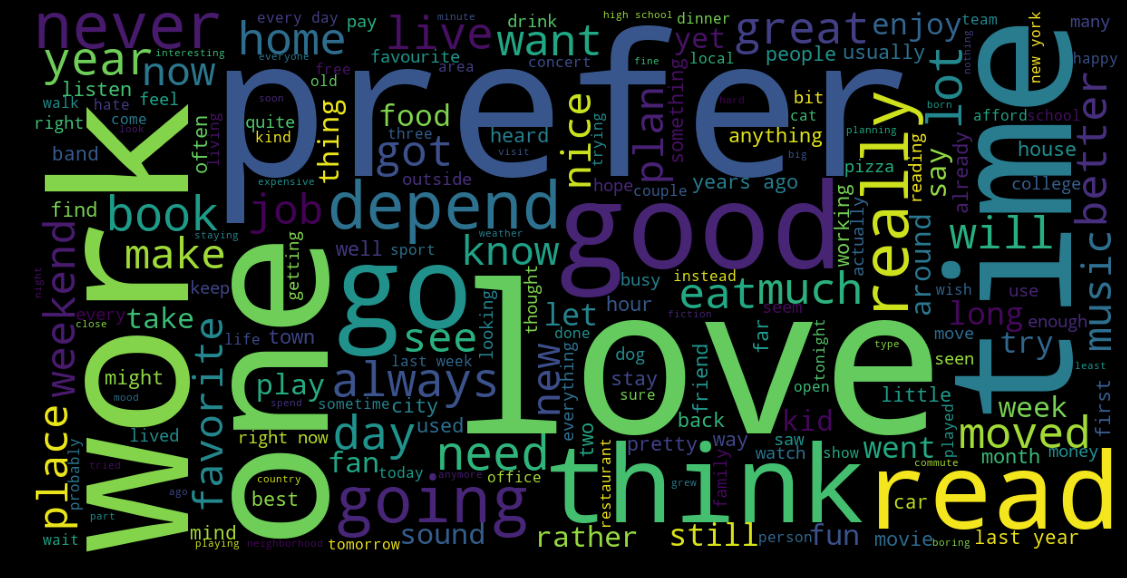

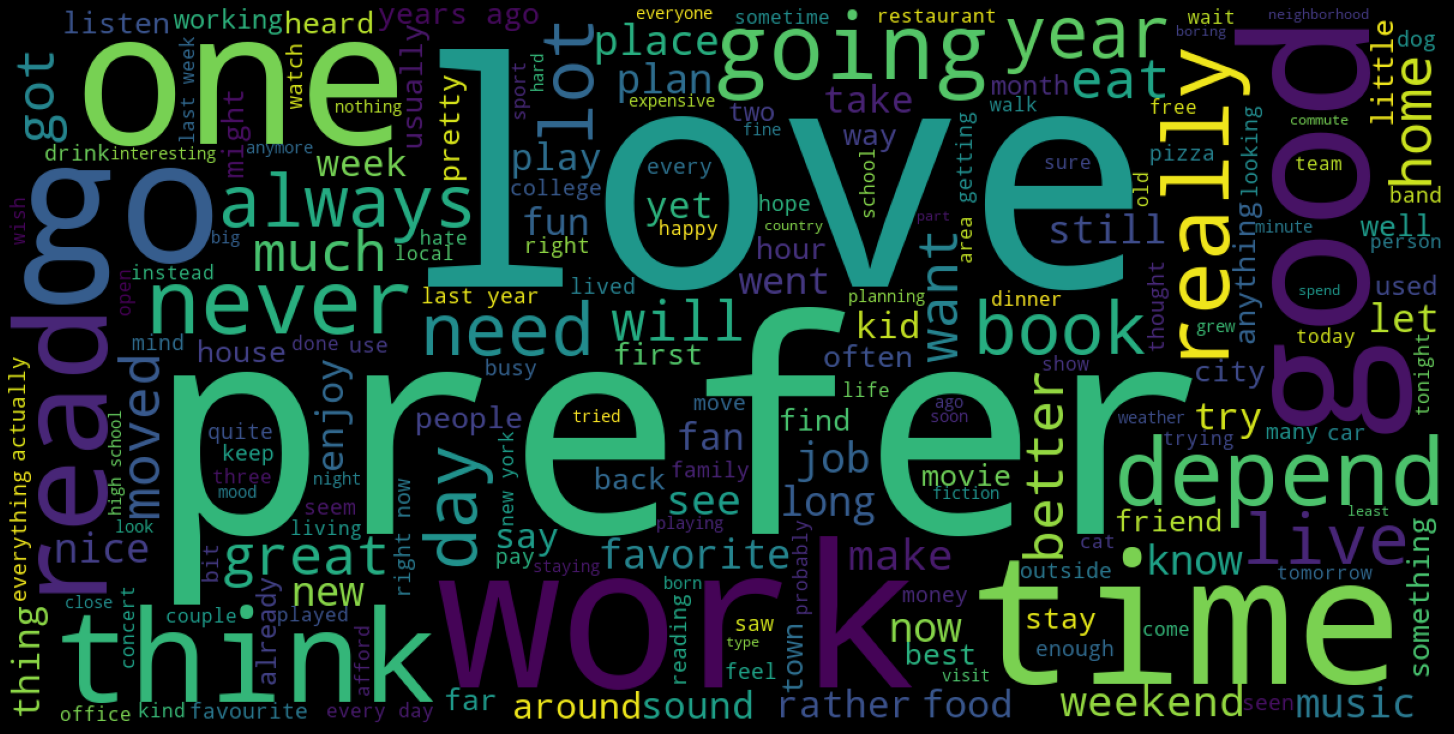

In [30]:
import warnings
warnings.filterwarnings('ignore') # Unrelated Pillow warnings

stopwords = set(STOPWORDS)
text1 = data['answer_Y_modified1'].str.cat(sep=' ')
text2 = data['answer_Y_modified2'].str.cat(sep=' ')

wordcloud1 = WordCloud(width=1200, height=600,stopwords=stopwords).generate(text1)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud1)

wordcloud2 = WordCloud(width=1200, height=600,stopwords=stopwords).generate(text2)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Word clouds looks similar, onto the next...

In [19]:
three_word_list = [x for x in data['answer_Y_modified2'] for x in trigrams(x.split())]
c_n_grams = Counter(three_word_list)
print(c_n_grams.most_common(5))

[(('i', 'have', 'a'), 434), (('that', 'would', 'be'), 280), (('a', 'lot', 'of'), 219), (('i', "don't", 'have'), 185), (('i', 'want', 'to'), 176)]


### Interesting observation here. The tuples of 3 show that many accepting responses differ by their denying counterparts with just one word.
### Consider the 5th trigram - ('i', 'want', 'to')

### Example question: Do you want to catch the new James Bond movie tomorrow?
### Example answer 1: I want to but I would prefer visiting the park more.
### Example answer 2: Not the biggest fan of such films but sure why not?

### Answer 1 implies that the person is accepting, but not wholeheartedly, as they prefer to do something else instead. So, despite containing words like 'I,' 'want,' and 'to,' which might suggest a yes, the answer also includes elements that hint at a no, such as 'but' and 'prefer.'

### Answer 2 similarly presents other challenging-to-interpret responses. It includes two instances of 'not.' The first instance hints at denial, while the second and last instance suggests acceptance.

In [21]:
vectorizer = CountVectorizer(analyzer='word',       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}')

data_vectorized = vectorizer.fit_transform(data['answer_Y_modified2'])
lda_model = LatentDirichletAllocation(n_components=10,
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1)
lda_output = lda_model.fit_transform(data_vectorized)

In [26]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  11.322913
6       0.648955  71.707100       2        1  11.065651
4      71.019684   9.971006       3        1  10.387302
1       3.785981  33.185135       4        1  10.236364
8     -42.666500  -9.222070       5        1  10.145208
3      -3.621689 -43.526516       6        1   9.954565
9      -3.632402  -4.171708       7        1   9.330013
7     -36.584400  35.804413       8        1   9.330008
5      44.391380  50.615383       9        1   9.300952
0      40.235809 -31.591665      10        1   8.927025, topic_info=         Term         Freq        Total Category  logprob  loglift
3479     like  1474.000000  1474.000000  Default  30.0000  30.0000
1755      don  1034.000000  1034.000000  Default  29.0000  29.0000
4637   prefer  1069.000000  1069.000000  Default  28.0000  28.0000
3582     love   986.000000   986.000000  Default  27.0000  27.0000
6850     work   792.000000   792.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1348     cool    54.887775    55.715019  Topic10  -4.8559   2.4011
5094     ride    52.074828    52.902096  Topic10  -4.9085   2.4003
1055    child    48.310201    49.137450  Topic10  -4.9835   2.3991
5296    scary    47.541229    48.368471  Topic10  -4.9996   2.3988
3426  learned    46.130916    46.958156  Topic10  -5.0297   2.3983

[336 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
69        9  0.984536       able
116       6  0.996406   actually
163      10  0.990529     afford
178       9  0.995626        ago
206       2  0.993310   allergic
...     ...       ...        ...
6880      5  0.995746     wouldn
6905      7  0.997598       year
6907      9  0.998444      years
6914      6  0.980056  yesterday
6917      3  0.988609       york

[306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 5, 2, 9, 4, 10, 8, 6, 1])

In [27]:
# Show top 20 keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=25):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=25)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24
Topic 0,enjoy,working,quite,use,lived,movie,tried,afford,close,playing,...,planning,parents,taking,pop,moving,flat,small,does,look,piano
Topic 1,work,live,need,lot,place,pretty,little,family,days,free,...,tomorrow,hate,weekends,dinner,drive,husband,lives,bike,minutes,important
Topic 2,prefer,read,just,home,long,books,try,new,stay,school,...,house,interesting,wait,hard,ones,jazz,mom,okay,fantasy,easy
Topic 3,depends,eat,food,week,got,day,want,let,times,spicy,...,weather,spend,current,thinking,fish,check,fast,yesterday,vegan,pick
Topic 4,don,time,going,favorite,know,right,town,usually,plan,mind,...,come,york,commute,genre,help,neighborhood,bad,art,short,trip
Topic 5,years,haven,job,ago,went,heard,seen,didn,saw,hope,...,married,expensive,mood,gave,lost,new,ready,morning,able,recently
Topic 6,like,good,better,sounds,fun,away,best,fiction,people,bit,...,pay,band,dog,doing,person,local,wanted,allergic,hour,eating
Topic 7,really,nice,weekend,fan,far,way,big,busy,isn,life,...,room,months,budget,took,kind,park,hungry,started,seeing,lessons
Topic 8,love,music,play,listen,looking,say,did,night,things,used,...,rock,makes,idea,novels,new,anymore,today,places,lots,dance
Topic 9,think,great,moved,year,make,just,plans,money,outside,movies,...,soon,state,watching,meet,interested,quiet,list,corner,tickets,run


In [33]:
df_topic_keywords.T

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,enjoy,work,prefer,depends,don,years,like,really,love,think
Word 1,working,live,read,eat,time,haven,good,nice,music,great
Word 2,quite,need,just,food,going,job,better,weekend,play,moved
Word 3,use,lot,home,week,favorite,ago,sounds,fan,listen,year
Word 4,lived,place,long,got,know,went,fun,far,looking,make
Word 5,movie,pretty,books,day,right,heard,away,way,say,just
Word 6,tried,little,try,want,town,seen,best,big,did,plans
Word 7,afford,family,new,let,usually,didn,fiction,busy,night,money
Word 8,close,days,stay,times,plan,saw,people,isn,things,outside
Word 9,playing,free,school,spicy,mind,hope,bit,life,used,movies


### Topic 9: Cinema and Weekend Activities
Words: "tickets," "watching," "movies".
Possible context: Cinema and weekend activities; People often buy tickets to watch movies during their weekends.
Divergent words are "born", "state", "year".
### Topic 8: Music
Possible context: Music.
### Topic 7: Living
Words: "living," "office," "room," "budget," "months," "hungry," "started," "seeing," "lessons".
Possible themes: Monthly budget for expenses, piano lessons, commuting to the office, relationships ("seeing someone").
### Topic 6: highly varied: but strong themes of Music and Food with minor themes of Weekend Activities
The divergent word "fiction" is related to books and movies but not music and food.
### Topic 5: School or College (Classmates)
Words: "haven," "seen," "years," "ago," "heard," "married," "expensive," "able," "recently," "trying".
Possible context: School or college life and classmates.
### Topic 4: Music and Possibly Living
Context is similar to topics 8 and 9, suggesting a mix of music, cinema and weekend activities.
### Topic 3: Food
Words: "eat," "food," "fish," "meat," "vegan," "pick," "spicy".
Context: Clearly food. The words are related to various aspects of food.
### Topic 2: Books
Words: "books," "book," "read," "fantasy," "read," "prefer," "fantasy".
Possible context: Books, particularly fantasy books. The divergent word is "jazz" (inverse condition of topic 6).
### Topic 1: Living
Words: "work," "live," "family," "free," "car," "friends," "weekends," "days," "husband".
Possible context: Living, family, and relationships again.
### Topic 0: Music and Living
A mix of music and living-related words.

In [34]:
data['context'].value_counts()

Y has just told X that he/she is thinking of buying a flat in New York.             3500
Y has just travelled from a different city to meet X.                               3487
X wants to know about Y's music preferences.                                        3483
Y has just told X that he/she is considering switching his/her job.                 3479
X wants to know what activities Y likes to do during weekends.                      3465
X and Y are colleagues who are leaving work on a Friday at the same time.           3452
X wants to know what sorts of books Y likes to read.                                3445
X and Y are childhood neighbours who unexpectedly run into each other at a cafe.    3391
Y has just moved into a neighbourhood and meets his/her new neighbour X.            3356
X wants to know about Y's food preferences.                                         3210
Name: context, dtype: int64